In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy as sc 
import numpy as np
import cvxpy as cvx

import sys
import os
import importlib

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import covariance_functions.general_functions as gf
import covariance_functions.em_functions as em
import covariance_functions.ewma_functions as ewma
import covariance_functions.regularization_functions as reg
import covariance_functions.backtest_functions as bt

importlib.reload(gf)
importlib.reload(em)
importlib.reload(ewma)
importlib.reload(reg)
importlib.reload(bt)


from covariance_functions.em_functions import *
from covariance_functions.ewma_functions import *
from covariance_functions.ewma_functions import _ewma_cov
from covariance_functions.ewma_functions import iterated_ewma
from covariance_functions.general_functions import *
from covariance_functions.regularization_functions import *
from covariance_functions.backtest_functions import *


import warnings
warnings.filterwarnings("ignore")

## Import Data and Data Pre-Processing

In [3]:
returns = pd.read_csv('data/SP500_top25_adjusted.csv')
returns = returns.set_index('Unnamed: 0')
returns = returns.rename_axis('Date', axis='index')
returns.index = pd.to_datetime(returns.index, format='%Y-%m-%d')

FF = pd.read_csv('data/ff5.csv')
FF = FF.set_index('Unnamed: 0')
FF = FF.rename_axis('Date', axis='index')
FF.index = pd.to_datetime(FF.index, format='%Y-%m-%d')

rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

In [4]:
mapping_data=pd.read_csv('data/permno_to_ticker_mapping.csv')
mapping_df = pd.DataFrame(mapping_data)
returns.columns = returns.columns.astype(str)
permno_to_ticker = dict(zip(mapping_df['PERMNO'].astype(str), mapping_df['tic']))
returns.rename(columns=permno_to_ticker, inplace=True)

In [20]:
returns
csv_file_path = 'data/returns_data.csv'
returns.to_csv(csv_file_path)
csv_file_path

'data/returns_data.csv'

## Add More Data - REITS

In [5]:
# Real Estate (REITs) - daily return from 
reit_returns = pd.read_csv('data/REIT_data.csv')
reit_ret_df = pd.DataFrame(reit_returns)
reit_ret_df['RETX'] = pd.to_numeric(reit_ret_df['RETX'], errors='coerce')
reit_ret_df['RET'] = pd.to_numeric(reit_ret_df['RET'], errors='coerce')
reit_ret_df['date'] = pd.to_datetime(reit_ret_df['date'], format='%m/%d/%y')
reit_ret_df=reit_ret_df.dropna()
reit_ret_df = reit_ret_df.pivot(index='date', columns='TICKER', values='RET')

tickers = ['NLY', 'PLD', 'SPG']

reit = reit_ret_df.filter(items=tickers)

## Add Commod Data

In [6]:
commod = pd.read_csv('data/commod_etf.csv')
commod = pd.DataFrame(commod)
commod['RETX'] = pd.to_numeric(commod['RETX'], errors='coerce')
commod['RET'] = pd.to_numeric(commod['RET'], errors='coerce')

commod['date'] = pd.to_datetime(commod['date'], format='%Y-%m-%d')

commod = commod.set_index('date')

commod = commod.pivot(columns='TICKER', values='RETX')

## Add PE Data

In [7]:
pe = pd.read_csv('data/pe_firm_etf.csv')
pe = pd.DataFrame(pe)
pe['RETX'] = pd.to_numeric(pe['RETX'], errors='coerce')
pe['RET'] = pd.to_numeric(pe['RET'], errors='coerce')

pe['date'] = pd.to_datetime(pe['date'], format='%Y-%m-%d')

pe = pe.set_index('date')

pe = pe.pivot(columns='TICKER', values='RETX')

## Combine Returns

In [8]:
returns_25 = returns.copy()
returns = returns.join([commod, reit, pe], how='inner')
returns = returns[returns.index >= '2012-01-01']

## Define Halflife Pairs
#### Specify the volatility halflife and covariance halflife for the EWMA

In [9]:
"""
rw_memory = rolling window size
    - reflect the number of trading days considered relevant.
    - 3 months = 60 days
    - 6 months = 125 days
    - 1 year = 250 days
ewma_halflife
iewma_pair = tuple (volatility halflife, covariance halflife) for a single iewma
cm_iewma_pairs = list of tuples of iewma_pairs
    - pairs are chosen to capture a variety of date ranges, from short term to 1 year
"""

rw_memory = 250
ewma_halflife=125
iewma_pair = (63,125)
cm_iewma_pairs = [(10, 21), (21, 63), (63, 125), (125, 250), (250, 500)]

## CM-IEWMA - Combined Multiple - Iterated Exponentially Weighted Moving Average


#### Start with IEWMA then combine it via SIGMA

In [10]:
# CM-IEWMA
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

# Regularize the first covariance matrix
fast = cm_iewma_pairs[0]
fast = f"{fast[0]}-{fast[1]}"
Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))

Running iterated_ewma
Running iterated_ewma
Running iterated_ewma
Running iterated_ewma
Running iterated_ewma


In [11]:
cm_iewma = {result.time: result.covariance for result in results}
weights = {result.time: result.weights for result in results}

Text(0.5, 1.0, 'Half-Life Weights Over Time')

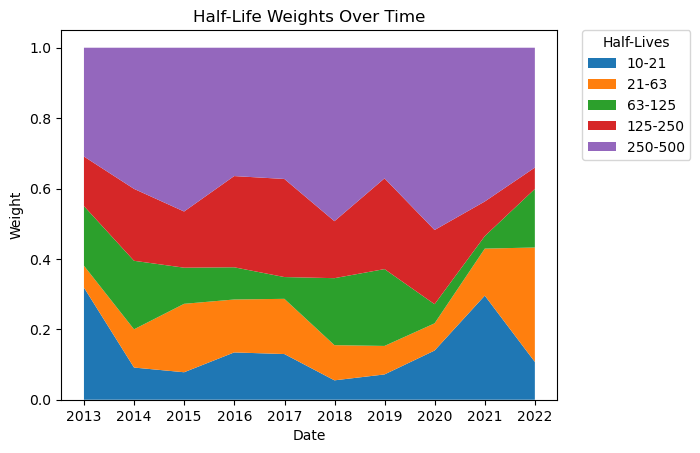

In [12]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("2011-12-28", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

quarterly_weights  = pd.DataFrame(weights).T.resample("YE").mean().loc[start_date:end_date]

plt.stackplot(quarterly_weights.index, quarterly_weights.values.T, labels=[f"{pair[0]}-{pair[1]}" for pair in cm_iewma_pairs])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Half-Lives')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.title('Half-Life Weights Over Time')

Text(0.5, 1.0, 'Average Volatility Half-Life Over Time')

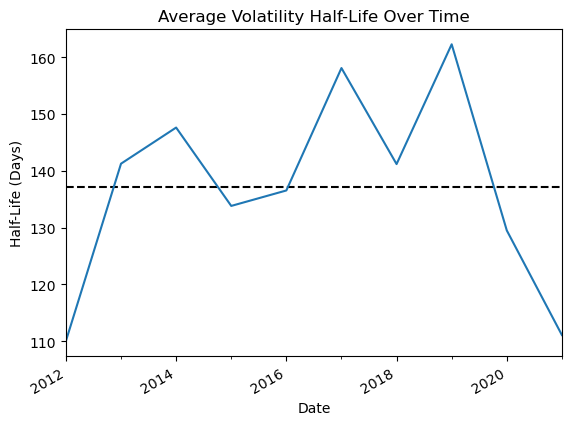

In [13]:
halflifes_vola = np.array([cm_iewma_pairs[i][0] for i in range(len(cm_iewma_pairs))])
(quarterly_weights * halflifes_vola).sum(axis=1).plot()
plt.axhline((quarterly_weights * halflifes_vola).sum(axis=1).mean(), color="black", linestyle="--", label="Mean half-life", zorder=-1)
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Half-Life (Days)')
plt.title('Average Volatility Half-Life Over Time')

## CM-IEWMA - Combined Multiple - Iterated Exponentially Weighted Moving Average (25 tickers only)


#### Start with IEWMA then combine it via SIGMA

In [14]:
# CM-IEWMA
iewmas_25 = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns_25, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63)) for pair in cm_iewma_pairs}
Sigmas_25 = {key: {item.time: item.covariance for item in iewma_25} for key, iewma_25 in iewmas_25.items()}

# Regularize the first covariance matrix
fast_25 = cm_iewma_pairs[0]; fast_25 = f"{fast_25[0]}-{fast_25[1]}"
Sigmas_25[fast_25] = add_to_diagonal(Sigmas_25[fast_25], lamda=0.05)

results_25 = list(from_sigmas(Sigmas_25, returns_25, means=None).solve(window=10))

Running iterated_ewma
Running iterated_ewma
Running iterated_ewma
Running iterated_ewma
Running iterated_ewma


In [15]:
cm_iewma_25 = {result_25.time: result_25.covariance for result_25 in results_25}
weights_25 = {result_25.time: result_25.weights for result_25 in results_25}


Text(0.5, 1.0, 'Half-Life Weights Over Time')

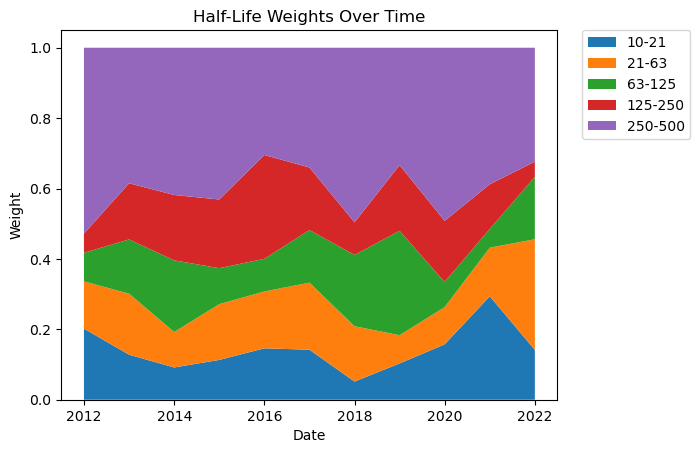

In [16]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("2011-12-28", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

quarterly_weights_25 = pd.DataFrame(weights_25).T.resample("YE").mean().loc[start_date:end_date]

plt.stackplot(quarterly_weights_25.index, quarterly_weights_25.values.T, labels=[f"{pair[0]}-{pair[1]}" for pair in cm_iewma_pairs])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Date')
plt.ylabel('Weight')
plt.title('Half-Life Weights Over Time')

Text(0.5, 1.0, 'Average Volatility Half-Life Over Time')

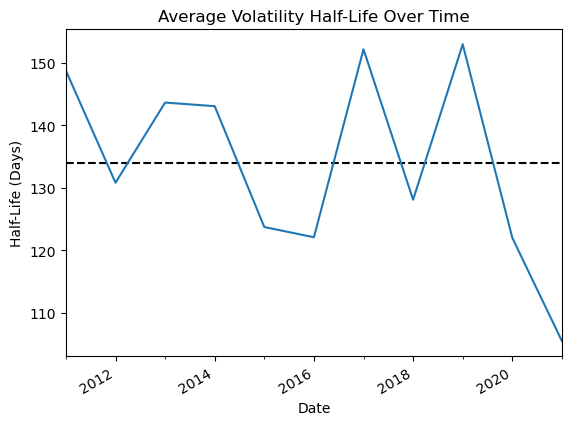

In [17]:
halflifes_vola_25 = np.array([cm_iewma_pairs[i][0] for i in range(len(cm_iewma_pairs))])
(quarterly_weights_25 * halflifes_vola).sum(axis=1).plot()
plt.axhline((quarterly_weights_25 * halflifes_vola_25).sum(axis=1).mean(), color="black", linestyle="--", label="Mean half-life", zorder=-1);
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Half-Life (Days)')
plt.title('Average Volatility Half-Life Over Time')

## Compare 25 tickers plus 7 extra to 25 tickers only

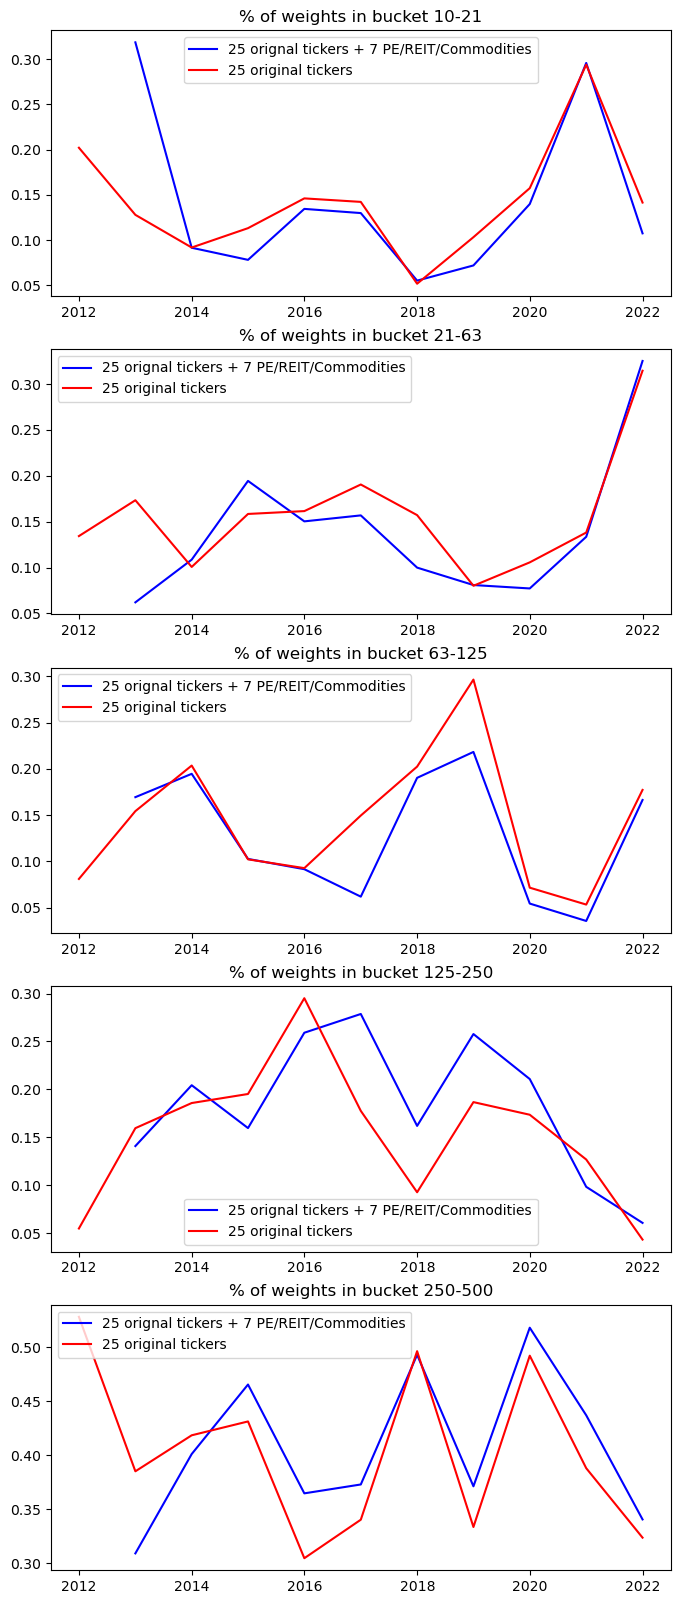

In [18]:
fig, ax = plt.subplots(nrows=len(quarterly_weights.columns), ncols=1, figsize=(8, 20))

for i in range(len(quarterly_weights.columns)):
    col = quarterly_weights.columns[i]
    ax[i].plot(quarterly_weights.index, quarterly_weights[col], color="blue", label="25 orignal tickers + 7 PE/REIT/Commodities")
    ax[i].plot(quarterly_weights_25.index, quarterly_weights_25[col], color="red", label="25 original tickers")
    ax[i].legend()
    ax[i].set_title(f'% of weights in bucket {col}')


## Other Covariance Estimation Methods for Comparison

In [19]:
# general_functions: rolling_window
rw = rolling_window(returns, rw_memory) 

# ewma_functions: ewma 
ewma = dict(_ewma_cov(returns, halflife=ewma_halflife))

#ewma_functions: iterated_ewma  
iewma = list(iterated_ewma(returns, vola_halflife=iewma_pair[0],cov_halflife=iewma_pair[1]))
iewma = {iterate.time: iterate.covariance for iterate in iewma}

# Prescient 
prescient = {}
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, axis=0)
    prescient[t] = pd.DataFrame(cov+np.outer(mean, mean), index=returns.columns, columns=returns.columns)

Running iterated_ewma


# Backtests - MSE, Log-Likelihood, Regrets

In [20]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("2012-01-01", format="%Y-%m-%d")
# start_date = pd.to_datetime("2010-01-04", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

In [21]:
names = ["RW", "EWMA", "IEWMA", "CM-IEWMA", "Prescient"]

predictors_temp = [rw, ewma, iewma, cm_iewma, prescient]
predictors = []

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

### MSE Calculation
##### Compares each method's predicted covariance matrix against actual realized covariances useing the MSE metric for each method on a quarterly basis (RW, EWMA, IEWMA, CM-IEWMA, Prescient)

In [22]:
for i, predictior in enumerate(predictors):
    MSE_temp = MSE(returns, predictior).resample("QE").mean()

    print("\n" + names[i])
    print(f"mean: {MSE_temp.mean():.6f}")
    print(f"std: {MSE_temp.std():.6f}")
    print(f"max: {MSE_temp.max():.6f}")


RW
mean: 0.000585
std: 0.002793
max: 0.018533

EWMA
mean: 0.000573
std: 0.002769
max: 0.018376

IEWMA
mean: 0.000566
std: 0.002726
max: 0.018087

CM-IEWMA
mean: 0.000539
std: 0.002498
max: 0.016171

Prescient
mean: 0.000522
std: 0.002517
max: 0.016690


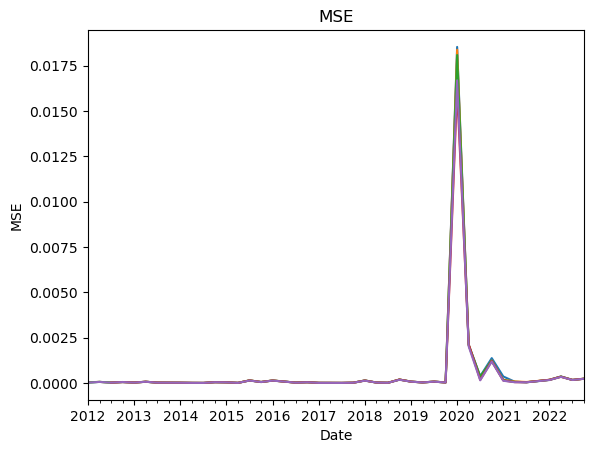

In [23]:
plt.figure()
for i, predictior in enumerate(predictors):
    MSE_temp = MSE(returns, predictior).resample("QE").mean()
    MSE_temp.plot()
    plt.title('MSE')
    plt.xlabel('Date')
    plt.ylabel('MSE')

### Log-Likelihood Calculation
##### Evaluate how well the covariance matrix fits the observed returns

In [24]:
log_likelihoods = {}

for i, predictor in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")
    returns_temp = returns.loc[pd.Series(predictor).index].values[1:]
    times = pd.Series(predictor).index[1:]
    Sigmas_temp = np.stack([predictor[t].values for t in predictor.keys()])[:-1]

    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["Prescient"] - log_likelihoods[name]

Computing RW log-likelihood...
Computing EWMA log-likelihood...
Computing IEWMA log-likelihood...
Computing CM-IEWMA log-likelihood...
Computing Prescient log-likelihood...


(50.0, 92.0)

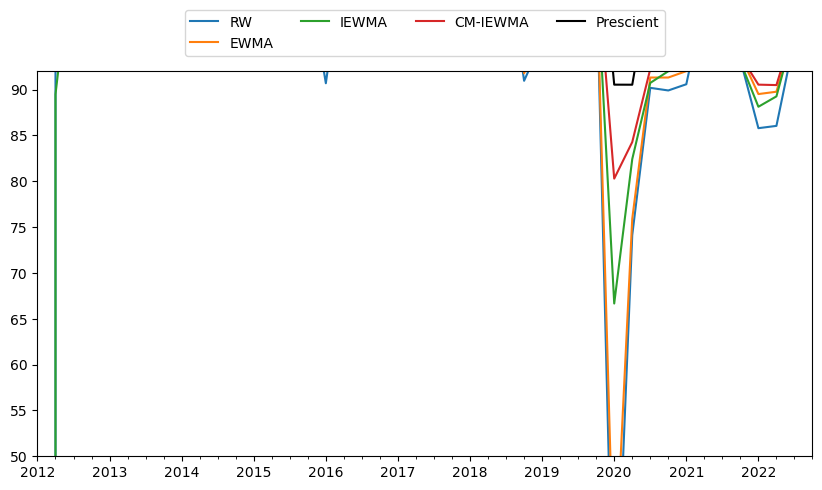

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'Prescient':
        log_likelihoods[name].resample("QE").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("QE").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5)
plt.ylim(50,92)

### Regrets Calculation 
##### Comparing the log-likelihood of each method against the prescient method (ideal benchmark)

Text(0, 0.5, 'Average quarterly regret')

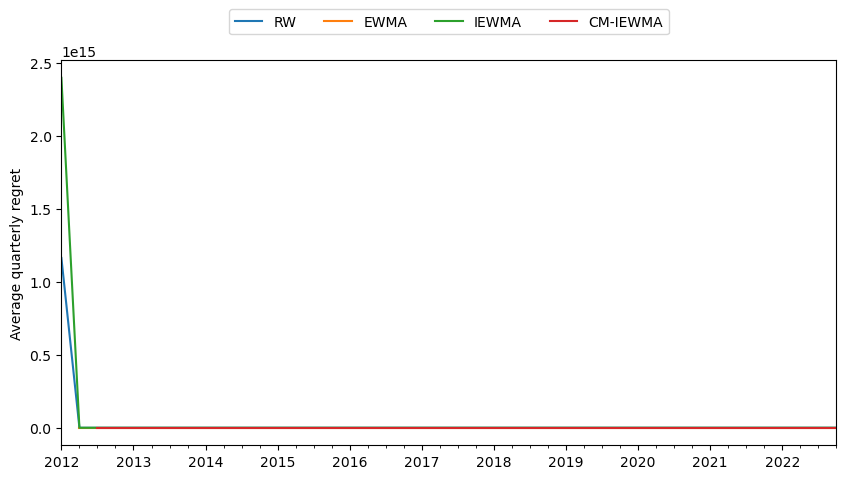

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'Prescient':
        pass
    else:
        regrets[name].resample("QE").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5)
plt.ylabel("Average quarterly regret")


Regret Metrics

In [27]:
# python friendly format
# Create a DataFrame to hold the table data
table_data = []

for name in regrets:
    if name != "PRESCIENT":
        # Ensure regret is a Series and handle any edge cases
        regret = regrets[name].resample("Q").mean()
        
        # Calculate metrics and use built-in round() for floats
        avg = round(np.mean(regret), 1)  # Rounds float values
        std_dev = round(np.std(regret), 1)  # Rounds float values
        max_val = round(np.max(regret), 1)  # Rounds float values
        
        # Append the results to table_data
        table_data.append([name, avg, std_dev, max_val])


# Create a DataFrame
columns = ['Predictor', 'Average', 'Std. dev.', 'Max']
df = pd.DataFrame(table_data, columns=columns)

# Display the DataFrame nicely
print(df)


   Predictor       Average     Std. dev.           Max
0         RW  2.641869e+13  1.732389e+14  1.162422e+15
1       EWMA          -inf           NaN  5.510000e+01
2      IEWMA  5.445218e+13  3.570668e+14  2.395896e+15
3   CM-IEWMA  8.500000e+00  1.300000e+00  1.220000e+01
4  Prescient  0.000000e+00  0.000000e+00  0.000000e+00
